# Infrastructure

In [222]:
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime
from collections import deque
import matplotlib.pyplot as plt

api_url = 'https://api.kraken.com'

In [106]:
def getOHLC(pair, interval):
    resp = requests.post('https://api.kraken.com/0/public/OHLC',
                         {'pair': pair, 'interval': interval}).json()
    
    df = pd.DataFrame((resp['result'])[list(resp['result'])[0]],
                      columns=['time', 'open', 'high', 'low',
                               'close', 'vwap', 'volume', 'count'])
    df['time'] = df['time'].apply(lambda x: datetime.fromtimestamp(x))
    df.set_index('time', inplace=True)
    df = df.astype('float')

    return df

def getOHLC_csv(file):
    data = pd.read_csv(file, names = ['time', 'open', 'high', 'low',
                               'close', 'vwap', 'volume', 'count'])
    data['time'] = data['time'].apply(lambda x: datetime.fromtimestamp(x))
    data.set_index('time', inplace=True)
    data = data.astype('float')
    
    return data

def getClose(pair, interval):
    df = getOHLC(pair, interval)
    return df['close']


In [107]:
def getEMA(data, window):
    calcs = data.ewm(span=window).mean()
    ema = calcs.iloc[-1, 0]

    return ema


def getListEMA(data, window):
    calcs = data.ewm(span=window).mean()

    return calcs


def getListSMA(data, window):
    calcs = data.rolling(window=window).mean()

    return calcs

In [210]:
# LOL apparently BIT isn't even bitcoin it's some other thing 
# these mfers didnt even have bitcoin in their historical data
# but yeah these are the most liquid (in terms of trade count)
#    non-stablecoin tokens on Kraken
top_liquid_coins = ['XBT', 'ETH', 'XRP', 'SOL', 'MATIC', 'AVAX', 'XMR',
                    'XDG', 'BCH', 'LTC', 'CHZ', 'TRX', 'LINK', 'ADA',
                    'ETC', 'UNI', 'SHIB', 'APT', 'DOT', 'FIL', 'ATOM']
# removed bnc

# to obtain from Kraken API
# histogram means difference between signal line (which is fast EMA - slow EMA) and the EMA of this signal line
def getMACDData(pair, interval, fast, slow, third):

    close = getClose(pair, interval=interval)

    diff_list = (getListEMA(close, window=fast) - getListEMA(close, window=slow))
    diff_ema = getListEMA(diff_list, window=third)

    df = pd.DataFrame(index=close.index)
    df['histogram'] = diff_list - diff_ema
    df['close'] = close
    df = df.astype('float')

    return df


# to obtain from csv files
def getMACDData_manual(data, fast, slow, third):

    close = pd.DataFrame(data['close'])

    diff_list = (getListEMA(close, window=fast) - getListEMA(close, window=slow))
    diff_ema = getListEMA(diff_list, window=third)

    df = pd.DataFrame(index=close.index)
    df['histogram'] = diff_list - diff_ema
    df['close'] = close
    df = df.astype('float')

    return df

# data: should come from getMACDData or getMACDData_manual, has to be specific format
# starting: starting cash, can rly be anything
# frac_traded: fraction of current cash to invest after each signal. Should NOT be 1 cause of fees
# trade_fee: the percentage of position size Kraken takes with every order (buy/sell) we make
# margin_fee: when shorting, the percentage of position size Kraken takes per every 4 hour 
def backtestMACD(data, starting=100, frac_traded=.99,
                 trade_fee=.0012, margin_fee=.0002):
    frac = frac_traded
    cash = starting
    holding_num = 0
    short_day = False
    indicator = 0
    num_trades = 0
    df = pd.DataFrame(index=data.index)
    df['num trades'] = num_trades
    df['holdings'] = 0
    df['cash'] = cash
    df['total'] = 0

    for i in range(1, len(data.index)):
        close = data.iloc[i, 1]
        this = data.iloc[i, 0]
        last = data.iloc[i - 1, 0]

        if indicator == -1:
            short_day = True
        elif indicator != -1:
            short_day = False

        # if in a short position, deduct margin fee
        if short_day:
            cash -= holding_num * close * (- margin_fee * 6)

        # hist rises above 0, enter long #
        if (this > 0) and (last < 0) and (indicator == 0):
            num_trades += 1
            indicator = 1
            holding_num += cash * frac / close
            cash -= holding_num * close * (1 + trade_fee)

        # exit long #
        elif (this < last) and (indicator == 1):
            num_trades += 1
            indicator = 0
            cash += holding_num * close * (1 - trade_fee)
            holding_num = 0

        # hist dips below 0, enter short #
        elif (this < 0) and (last > 0) and (indicator == 0):
            num_trades += 1
            indicator = -1
            holding_num -= cash * frac / close
            cash -= holding_num * close * (1 - trade_fee - margin_fee)

        # exit short #
        elif (this > last) and (indicator == -1):
            num_trades += 1
            indicator = 0
            cash += holding_num * close * (1 + trade_fee)
            holding_num = 0

        # corner cases where the peak only lasts one period #
        elif (this > 0) and (indicator == -1):
            num_trades += 1
            indicator = 1
            holding_num += 2 * cash * frac / close
            cash -= holding_num * close * (1 + trade_fee)

        elif (this < 0) and (indicator == 1):
            num_trades += 1
            indicator = -1
            holding_num -= 2 * cash * frac / close
            cash -= holding_num * close * (1 - trade_fee - margin_fee)

        # send info into df
        df.iloc[i, 0] = num_trades
        df.iloc[i, 1] = holding_num * close
        df.iloc[i, 2] = cash
        df['total'] = df['cash'] + df['holdings']
    df['% change'] = df['total'].pct_change()

    return df

In [109]:
# may have to update risk free rate lol
def getSharpe(returns, periods, rfr=.02989):
    result = returns['% change'].iloc[2:] + 1
    result = result.resample(periods).prod() - 1

    if periods == '1D':
        mean_excess = result.mean() * 365 - rfr
        vol = result.std() * (365 ** 0.5)

    elif periods == '1M':
        mean_excess = result.mean() * 12 - rfr
        vol = result.std() * (12 ** 0.5)

    sharpe = mean_excess / vol

    df = pd.DataFrame(columns=['Mean', 'Vol', 'Sharpe'], index=['Strat'])
    df['Mean'] = mean_excess
    df['Vol'] = vol
    df['Sharpe'] = sharpe

    return df

In [158]:
# returns df of sharpe ratios over the given time period (index), given the parameters
# index indicates how many intervals in analysis (e.g. past 100 days)
# from: 
def rankCoins(fast, slow, third, trade_fee=0, margin_fee=0):
    
    start_date = '2020-02-01 18:00:00'
    end_date = '2022-02-01 18:00:00'
    dct = dict()

    for coin_name in good_top_liquid_coins:
        #print(f'now on: {coin_name}')
        filename = coin_name + 'USD_1440.csv'
        ohlc = getOHLC_csv(filename)
        
        start_loc = ohlc.index.get_loc(start_date)
        end_loc = ohlc.index.get_loc(end_date)

        data = getMACDData_manual(ohlc, fast=fast, slow=slow, third=third).iloc[start_loc:end_loc]

        returns = backtestMACD(data, starting=100,
                                   trade_fee=trade_fee, margin_fee=0, frac_traded=.99)
    
        sharpe = getSharpe(returns, '1M')['Sharpe'].values[0]
        dct[coin_name] = sharpe
        title = ''

    df = pd.DataFrame.from_dict(dct, orient='index', columns=['sharpes'])
    df.sort_values(by=['sharpes'], ascending=False, inplace=True)
    return df

In [259]:
# comparing against basket of coins
def getHoldReturns(pair, interval):
    data = getClose(pair, interval)
    df = pd.DataFrame()
    df['close'] = data
    df['% change'] = df['close'].pct_change()

    return df

In [294]:
def plotMACD(data):

    x = data.index
    y1 = data['histogram']
    y2 = data['close']
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(x, y2, label='close')
    ax2.plot(x, y1, label='histogram')
    ax1.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax2.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax1.grid(which='major')
    ax1.grid(which='minor')
    ax2.grid(which='major')
    ax2.grid(which='minor')
    fig.autofmt_xdate(rotation=45)
    fig.show()

# Strategy

data downloaded directly from Kraken, no need for API
Using Kraken + Crypto because it is easy to implement IRL with limited funds. Exists API with extensive documentation, and transparant trading fees. Additionally, it may be a less efficient asset class, with many many retail investors (though this may not be the case anymore)

MACD since it's simple yet effective capture of momentum, plus backtests better than bollinger bands

We seek to build a strategy ***which we may implement right now***, with limited capital requirements

### Thesis:

crypto markets aren't quite efficient, and due to perhaps high number of retail investors, may have high 'price inertia'

### Challenges:

- frequently occuring 'black swan' events: this is actually what we seek to capture!

- optimization: ~4 parameters, and over-optimizing may lead to bad overfitting, which is a possibility considering number of parameters and coins we use.
- - we may just eyeball it

- relative lack of data in crypto: only up to ~4 yearsish of reliable data


### Risk Areas:

- obviously don't know if past data/trends still hold for crypto, since big fundamental shifts in industry: see FTX collapse, increasing regulation, etc

- counterparty risk: again, see FTX collapse and regulations. What if kraken goes heads up sometime?

- directional bets: perhaps high payoff, but can easily blow up on us

- don't understand fundamental pricing tbh -- no 'theoretical' background for why ideas work 

### Areas of Improvement:

- bet sizing: size positions by MACD signal strength perhaps?
- optimization: we could use ML but would take shit ton of computing time/power, especially across 3 (possibly 4) parameters and 20 coins


# Getting Coins with Enough Data
Lots of coins simply do not have enough data to gain meaningful results from. We want to train on a two-year period from 2-01-2020 to 2-01-2022. We generate a list of such coins with data from this time period.

In [159]:
good_top_liquid_coins = []

for coin in top_liquid_coins:
    filename = coin + 'USD_1440.csv'
    ohlc = getOHLC_csv(filename)
    if len(ohlc.index) <= 730:
        continue
    position = ohlc.index.get_loc('2022-02-01 18:00:00')
    if position > 730:
        good_top_liquid_coins.append(coin)
        
print(good_top_liquid_coins)

['XBT', 'ETH', 'XRP', 'XMR', 'XDG', 'BCH', 'LTC', 'LINK', 'ADA', 'ETC', 'ATOM']


# Coin / Parameter Optimization

Should choose coins which display robust performance across variety of parameters

In [160]:
# (4, 10, 4)

print('4, 10, 4')
print(rankCoins(4, 10, 4, trade_fee=.0012, margin_fee=.0002))

       sharpes
ETC   0.596751
LTC   0.115396
ATOM  0.016566
ADA  -0.096497
LINK -0.213627
ETH  -0.450292
XBT  -0.489857
XDG  -0.647287
BCH  -0.818097
XMR  -0.933701
XRP  -1.041207


In [162]:
# (7, 15, 6)

print(rankCoins(7, 15, 6, trade_fee=.0012, margin_fee=.0002))

       sharpes
ETC   1.327145
LTC   0.906932
XDG   0.531772
XRP   0.205291
BCH   0.145719
LINK -0.157560
XBT  -0.236674
ETH  -0.259505
XMR  -0.567219
ADA  -0.644181
ATOM -0.778257


In [163]:
# (10, 24, 6)

print(rankCoins(10, 24, 6, trade_fee=.0012, margin_fee=.0002))

       sharpes
ETC   0.967898
XBT   0.119677
XDG   0.072345
LINK  0.054841
BCH   0.047181
ETH   0.019666
XRP  -0.058102
LTC  -0.156926
XMR  -0.370757
ADA  -0.586899
ATOM -0.767906


In [164]:
# (12, 30, 10)

print(rankCoins(12, 30, 10, trade_fee=.0012, margin_fee=.0002))

       sharpes
ATOM  0.751034
LINK  0.726815
ADA   0.726027
BCH   0.544098
ETC   0.499454
ETH   0.482732
XBT   0.166982
LTC  -0.159794
XRP  -1.085077
XDG  -1.260387
XMR  -1.495696


In [165]:
# (18, 40, 16)

print(rankCoins(18, 40, 16, trade_fee=.0012, margin_fee=.0002))

       sharpes
ETH   0.724053
ADA   0.403306
LINK  0.284145
XDG   0.182671
BCH   0.182245
XRP   0.165266
ATOM -0.043151
ETC  -0.069875
LTC  -0.100828
XBT  -0.197837
XMR  -0.250007


Note how **ETC** does incredibly well across wide span of parameters. **ADA** and **LINK** are quite good over long windows. Everything else seems due to noise.
Picking coins with robust performances also ***reduces risk of overfitting***

### Optimizing on ETC, ADA, LINK

In [166]:
start_date = '2020-02-01 18:00:00'
end_date = '2022-02-01 18:00:00'

#### ETC

In [167]:
# Wide Optimization #
slows = [i for i in range(10, 28)]

train_sharpes = []
ohlc = getOHLC_csv('ETCUSD_1440.csv')
start_loc = ohlc.index.get_loc(start_date)
end_loc = ohlc.index.get_loc(end_date)

for slow in slows:
    for fast in range(int(slow/4), int(slow/2)+1):
        third = fast
        
        data = getMACDData_manual(ohlc, fast=fast, slow=slow, third=third).iloc[start_loc:end_loc]
        returns = backtestMACD(data, starting=100,
                                   trade_fee=.0012, margin_fee=.0002, frac_traded=.99)
        sharpe = getSharpe(returns, '1M')['Sharpe'].values[0]
        train_sharpes.append({'fast': fast, 'slow': slow, 'third': third, 'sharpe': sharpe})
        
etc_brute_force = pd.DataFrame.from_dict(train_sharpes)
etc_brute_force.sort_values(by=['sharpe'], ascending=False, inplace=True)

print(etc_brute_force)


    fast  slow  third    sharpe
20     7    14      7  1.982863
25     7    15      7  1.966804
29     7    16      7  1.945690
45     7    19      7  1.916978
50     7    20      7  1.841250
..   ...   ...    ...       ...
8      3    12      3 -0.017626
1      3    10      3 -0.069968
5      3    11      3 -0.229023
4      2    11      2 -1.683236
0      2    10      2 -1.708596

[104 rows x 4 columns]


We see above that fasts/thirds around 7 and slows around 14-20 are optimal, with most parameters having positive sharpe! To find the exact optimized parameters:

In [168]:
# Narrow Optimization
slows = [i for i in range(14, 21)]

train_sharpes = []
ohlc = getOHLC_csv('ETCUSD_1440.csv')
start_loc = ohlc.index.get_loc(start_date)
end_loc = ohlc.index.get_loc(end_date)

for slow in slows:
    for fast in range(6, 10):
        for third in range(6, 10):
            data = getMACDData_manual(ohlc, fast=fast, slow=slow, third=third).iloc[start_loc:end_loc]
            returns = backtestMACD(data, starting=100,
                                   trade_fee=.0012, margin_fee=.0002, frac_traded=.99)
            sharpe = getSharpe(returns, '1M')['Sharpe'].values[0]
            train_sharpes.append({'fast': fast, 'slow': slow, 'third': third, 'sharpe': sharpe})
        
etc_specified = pd.DataFrame.from_dict(train_sharpes)
etc_specified.sort_values(by=['sharpe'], ascending=False, inplace=True)

print(etc_specified)

     fast  slow  third    sharpe
5       7    14      7  1.982863
56      8    17      6  1.978257
50      6    17      8  1.978257
24      8    15      6  1.972606
18      6    15      8  1.972606
..    ...   ...    ...       ...
79      9    18      9  1.029583
63      9    17      9  1.021629
107     8    20      9  0.987367
110     9    20      8  0.987367
111     9    20      9  0.964017

[112 rows x 4 columns]


It's good to see that all 112 combinations return a sharpe ~> 1. We choose **(8, 17, 6)** as the range of parameters around it performed the best.
Use gradient descent for future

#### ADA

In [169]:
# Wide Optimization #
slows = [i for i in range(28, 43, 2)]

# third = fast
train_sharpes = []
ohlc = getOHLC_csv('ADAUSD_1440.csv')
start_loc = ohlc.index.get_loc(start_date)
end_loc = ohlc.index.get_loc(end_date)

for slow in slows:
    for fast in range(int(slow/4) + (slow % 4 > 0), int(slow/2)+1):
        third = fast
        #print(f'now on: {fast}, {slow}, {third}')
        data = getMACDData_manual(ohlc, fast=fast, slow=slow, third=third).iloc[start_loc:end_loc]
        returns = backtestMACD(data, starting=100,
                                   trade_fee=.0012, margin_fee=.0002, frac_traded=.99)
        sharpe = getSharpe(returns, '1M')['Sharpe'].values[0]
        train_sharpes.append({'fast': fast, 'slow': slow, 'third': third, 'sharpe': sharpe})
        
ada_brute_force = pd.DataFrame.from_dict(train_sharpes)
ada_brute_force.sort_values(by=['sharpe'], ascending=False, inplace=True)

print(ada_brute_force)


    fast  slow  third    sharpe
11    11    30     11  0.685314
19    11    32     11  0.631483
5     12    28     12  0.620011
4     11    28     11  0.586080
35    10    36     10  0.573926
..   ...   ...    ...       ...
64    20    40     20 -0.478059
8      8    30      8 -0.485496
74    20    42     20 -0.539961
0      7    28      7 -0.693851
1      8    28      8 -0.749718

[76 rows x 4 columns]


We see there is a local peaks: around ~(30, 11, 11). Optimizing:

In [171]:
# Narrow Optimization
slows = [i for i in range(28, 33)]

# third = fast
train_sharpes = []
ohlc = getOHLC_csv('ADAUSD_1440.csv')
start_loc = ohlc.index.get_loc(start_date)
end_loc = ohlc.index.get_loc(end_date)

for slow in slows:
    for fast in range(9, 13):
        for third in range(9, 13):
            #print(f'now on: {fast}, {slow}, {third}')
            data = getMACDData_manual(ohlc, fast=fast, slow=slow, third=third).iloc[start_loc:end_loc]
            returns = backtestMACD(data, starting=100,
                                   trade_fee=.0012, margin_fee=.0002, frac_traded=.99)
            sharpe = getSharpe(returns, '1M')['Sharpe'].values[0]
            train_sharpes.append({'fast': fast, 'slow': slow, 'third': third, 'sharpe': sharpe})
        
ada_specified = pd.DataFrame.from_dict(train_sharpes)
ada_specified.sort_values(by=['sharpe'], ascending=False, inplace=True)

print(ada_specified)


    fast  slow  third    sharpe
61    12    31     10  0.740822
55    10    31     12  0.740822
58    11    31     11  0.727578
30    12    29     11  0.695713
27    11    29     12  0.695713
..   ...   ...    ...       ...
24    11    29      9  0.252177
18     9    29     11  0.252177
32     9    30      9  0.163868
0      9    28      9  0.148745
16     9    29      9  0.139801

[80 rows x 4 columns]


Backtest results for the ~(12, 31, 10) range are excellent, with every single of the 80 combinations having a sharpe > 0. We thus use **(12, 31, 10)** as our parameters.

#### LINK

In [172]:
# Wide Optimization #
slows = [i for i in range(28, 43, 2)]

# third = fast
train_sharpes = []
ohlc = getOHLC_csv('LINKUSD_1440.csv')
start_loc = ohlc.index.get_loc(start_date)
end_loc = ohlc.index.get_loc(end_date)

for slow in slows:
    for fast in range(int(slow/4) + (slow % 4 > 0), int(slow/2)+1):
        third = fast
        #print(f'now on: {fast}, {slow}, {third}')
        data = getMACDData_manual(ohlc, fast=fast, slow=slow, third=third).iloc[start_loc:end_loc]
        returns = backtestMACD(data, starting=100,
                                   trade_fee=.0012, margin_fee=.0002, frac_traded=.99)
        sharpe = getSharpe(returns, '1M')['Sharpe'].values[0]
        train_sharpes.append({'fast': fast, 'slow': slow, 'third': third, 'sharpe': sharpe})
        
link_brute_force = pd.DataFrame.from_dict(train_sharpes)
link_brute_force.sort_values(by=['sharpe'], ascending=False, inplace=True)

print(link_brute_force)


    fast  slow  third    sharpe
56    12    40     12  1.456847
46    12    38     12  1.300813
66    12    42     12  1.211715
37    12    36     12  1.008342
5     12    28     12  0.990604
..   ...   ...    ...       ...
17     9    32      9  0.044919
58    14    40     14  0.034788
39    14    36     14 -0.080748
48    14    38     14 -0.162496
75    21    42     21 -0.581585

[76 rows x 4 columns]


Optimize around (12, 40, 12)

In [174]:
# Narrow Optimization
slows = [i for i in range(36, 44)]

# third = fast
train_sharpes = []
ohlc = getOHLC_csv('LINKUSD_1440.csv')
start_loc = ohlc.index.get_loc(start_date)
end_loc = ohlc.index.get_loc(end_date)

for slow in slows:
    for fast in range(10, 14):
        for third in range(10, 14):
            #print(f'now on: {fast}, {slow}, {third}')
            data = getMACDData_manual(ohlc, fast=fast, slow=slow, third=third).iloc[start_loc:end_loc]
            returns = backtestMACD(data, starting=100,
                                   trade_fee=.0012, margin_fee=.0002, frac_traded=.99)
            sharpe = getSharpe(returns, '1M')['Sharpe'].values[0]
            train_sharpes.append({'fast': fast, 'slow': slow, 'third': third, 'sharpe': sharpe})
        
link_specified = pd.DataFrame.from_dict(train_sharpes)
link_specified.sort_values(by=['sharpe'], ascending=False, inplace=True)

print(link_specified)


     fast  slow  third    sharpe
74     12    40     12  1.456847
93     13    41     11  1.412606
87     11    41     13  1.412606
77     13    40     11  1.349117
71     11    40     13  1.349117
..    ...   ...    ...       ...
64     10    40     10  0.333984
31     13    37     13  0.324474
127    13    43     13  0.308816
47     13    38     13  0.254727
15     13    36     13  0.159487

[128 rows x 4 columns]


**(12, 40, 12)** it is

### Portfolio Weightings

Let's arbitrarily call it at 50/25/25 ETC / SOL / FIL ?

Ideally we'd run regressions to create some MV portfolio. Meh

- 33.3%: ETCUSD (8, 17, 6)
- 33.3% ADA (12, 31, 10)
- 33.3% LINK (12, 40, 12)

# Backtesting 

Should include sharpe, max drawdown, winrate, and comparison to dummy portfolio of just the coins

In [188]:
test_start_date = "2022-02-01 18:00:00"
test_end_date = "2023-02-01 18:00:00"

In [232]:
etc_test_ohlc = getOHLC('ETCUSD', 1440)
start_loc = etc_test_ohlc.index.get_loc(test_start_date)
end_loc = etc_test_ohlc.index.get_loc(test_end_date)

etc_test_macd = getMACDData_manual(etc_test_ohlc, fast=8, slow=17, third=6).iloc[start_loc:end_loc]

etc_test_returns = backtestMACD(etc_test_macd, starting=33.33,
                                   trade_fee=.0012, margin_fee=.0002, frac_traded=.99)

display(etc_test_returns)

,num trades,holdings,cash,total,% change
time,,,,,
2022-02-01 18:00:00,0,0.0,33.330000,33.330000,NaN
2022-02-02 18:00:00,0,0.0,33.330000,33.330000,0.0
2022-02-03 18:00:00,0,0.0,33.330000,33.330000,0.0
2022-02-04 18:00:00,0,0.0,33.330000,33.330000,0.0
2022-02-05 18:00:00,0,0.0,33.330000,33.330000,0.0
...,...,...,...,...,...
2023-01-27 18:00:00,64,0.0,29.059775,29.059775,0.0
2023-01-28 18:00:00,64,0.0,29.059775,29.059775,0.0
2023-01-29 18:00:00,64,0.0,29.059775,29.059775,0.0


In [230]:
ada_test_ohlc = getOHLC('ADAUSD', 1440)
start_loc = ada_test_ohlc.index.get_loc(test_start_date)
end_loc = ada_test_ohlc.index.get_loc(test_end_date)

ada_test_macd = getMACDData_manual(ada_test_ohlc, fast=12, slow=31, third=10).iloc[start_loc:end_loc]

ada_test_returns = backtestMACD(ada_test_macd, starting=33.34,
                                   trade_fee=.0012, margin_fee=.0002, frac_traded=.99)

display(ada_test_returns)

,num trades,holdings,cash,total,% change
time,,,,,
2022-02-01 18:00:00,0,0.000000,33.340000,33.340000,NaN
2022-02-02 18:00:00,0,0.000000,33.340000,33.340000,0.000000
2022-02-03 18:00:00,1,33.006600,0.293792,33.300392,-0.001188
2022-02-04 18:00:00,1,32.635055,0.293792,32.928848,-0.011157
2022-02-05 18:00:00,1,33.135278,0.293792,33.429071,0.015191
...,...,...,...,...,...
2023-01-27 18:00:00,36,0.000000,49.148707,49.148707,0.000000
2023-01-28 18:00:00,36,0.000000,49.148707,49.148707,0.000000
2023-01-29 18:00:00,36,0.000000,49.148707,49.148707,0.000000


In [233]:
link_test_ohlc = getOHLC('LINKUSD', 1440)
start_loc = link_test_ohlc.index.get_loc(test_start_date)
end_loc = link_test_ohlc.index.get_loc(test_end_date)

link_test_macd = getMACDData_manual(link_test_ohlc, fast=12, slow=40, third=12).iloc[start_loc:end_loc]

link_test_returns = backtestMACD(link_test_macd, starting=33.33,
                                   trade_fee=.0012, margin_fee=.0002, frac_traded=.99)

display(link_test_returns)

,num trades,holdings,cash,total,% change
time,,,,,
2022-02-01 18:00:00,0,0.000000,33.330000,33.330000,NaN
2022-02-02 18:00:00,0,0.000000,33.330000,33.330000,0.000000
2022-02-03 18:00:00,0,0.000000,33.330000,33.330000,0.000000
2022-02-04 18:00:00,1,32.996700,0.293704,33.290404,-0.001188
2022-02-05 18:00:00,1,33.500709,0.293704,33.794413,0.015140
...,...,...,...,...,...
2023-01-27 18:00:00,36,0.000000,26.882499,26.882499,0.000000
2023-01-28 18:00:00,36,0.000000,26.882499,26.882499,0.000000
2023-01-29 18:00:00,36,0.000000,26.882499,26.882499,0.000000


In [234]:
total_returns = pd.DataFrame(link_test_returns['total'] + ada_test_returns['total'] + etc_test_returns['total'])
total_returns['% change'] = total_returns['total'].pct_change()
display(total_returns)
display(getSharpe(total_returns, '1M'))

,total,% change
time,,
2022-02-01 18:00:00,100.000000,NaN
2022-02-02 18:00:00,100.000000,0.000000
2022-02-03 18:00:00,99.960392,-0.000396
2022-02-04 18:00:00,99.549252,-0.004113
2022-02-05 18:00:00,100.553484,0.010088
...,...,...
2023-01-27 18:00:00,105.090981,0.000000
2023-01-28 18:00:00,105.090981,0.000000
2023-01-29 18:00:00,105.090981,0.000000


,Mean,Vol,Sharpe
Strat,0.087496,0.400441,0.218499


A poor showing, but not the worst in the world

In [247]:
monthly_test_results = total_returns['% change'].iloc[2:] + 1
monthly_test_results = monthly_test_results.resample('1M').prod() - 1

display(monthly_test_results)
print(f'max drawdown: {round(monthly_test_results.min(),3)}')

time
2022-02-28    0.026866
2022-03-31    0.286900
2022-04-30    0.034752
2022-05-31   -0.116172
2022-06-30   -0.127760
2022-07-31    0.017709
2022-08-31    0.000461
2022-09-30   -0.035266
2022-10-31   -0.045632
2022-11-30   -0.052648
2022-12-31   -0.034533
2023-01-31    0.162711
Freq: M, Name: % change, dtype: float64

max drawdown: -0.128


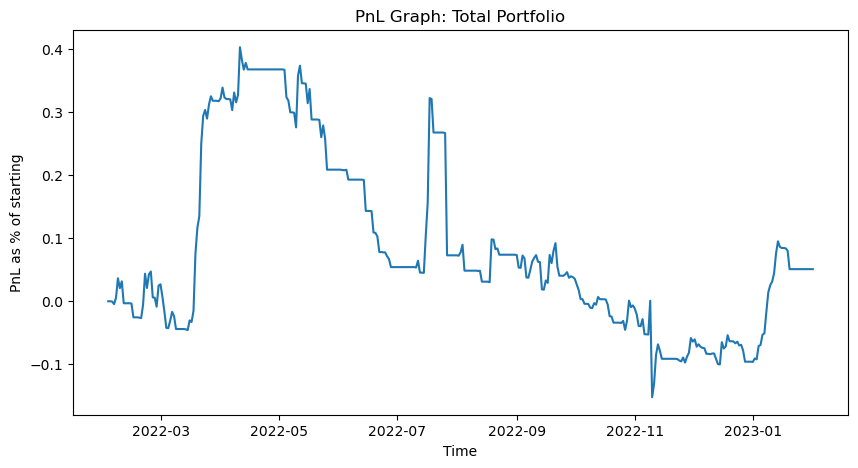

In [289]:
plt.figure(figsize=(10,5))
plt.plot((total_returns['total']-100)/100)
plt.title('PnL Graph: Total Portfolio')
plt.xlabel('Time')
plt.ylabel('PnL as % of starting')
plt.show()

### Compared against holding coins:

In [270]:
etc_hold = getHoldReturns('ETCUSD', 1440)
start_loc = etc_hold.index.get_loc(test_start_date)
end_loc = etc_hold.index.get_loc(test_end_date)
etc_hold = etc_hold.iloc[start_loc:end_loc]

print(etc_hold)

                      close  % change
time                                 
2022-02-01 18:00:00  26.313 -0.019525
2022-02-02 18:00:00  27.871  0.059210
2022-02-03 18:00:00  29.739  0.067023
2022-02-04 18:00:00  29.445 -0.009886
2022-02-05 18:00:00  29.871  0.014468
...                     ...       ...
2023-01-27 18:00:00  21.578 -0.018691
2023-01-28 18:00:00  22.826  0.057837
2023-01-29 18:00:00  21.323 -0.065846
2023-01-30 18:00:00  21.692  0.017305
2023-01-31 18:00:00  22.435  0.034252

[365 rows x 2 columns]


In [268]:
ada_hold = getHoldReturns('ADAUSD', 1440)
start_loc = ada_hold.index.get_loc(test_start_date)
end_loc = ada_hold.index.get_loc(test_end_date)
ada_hold = ada_hold.iloc[start_loc:end_loc]

print(ada_hold)

                        close  % change
time                                   
2022-02-01 18:00:00  1.027207 -0.062570
2022-02-02 18:00:00  1.060188  0.032107
2022-02-03 18:00:00  1.138880  0.074225
2022-02-04 18:00:00  1.126060 -0.011257
2022-02-05 18:00:00  1.143320  0.015328
...                       ...       ...
2023-01-27 18:00:00  0.382175 -0.019813
2023-01-28 18:00:00  0.397813  0.040918
2023-01-29 18:00:00  0.372584 -0.063419
2023-01-30 18:00:00  0.390539  0.048190
2023-01-31 18:00:00  0.396702  0.015781

[365 rows x 2 columns]


In [271]:
link_hold = getHoldReturns('linkUSD', 1440)
start_loc = link_hold.index.get_loc(test_start_date)
end_loc = link_hold.index.get_loc(test_end_date)
link_hold = link_hold.iloc[start_loc:end_loc]

print(link_hold)

                        close  % change
time                                   
2022-02-01 18:00:00  15.85526 -0.066896
2022-02-02 18:00:00  16.29993  0.028046
2022-02-03 18:00:00  17.52511  0.075165
2022-02-04 18:00:00  17.80873  0.016184
2022-02-05 18:00:00  18.08075  0.015275
...                       ...       ...
2023-01-27 18:00:00   7.20891 -0.022786
2023-01-28 18:00:00   7.38077  0.023840
2023-01-29 18:00:00   6.91156 -0.063572
2023-01-30 18:00:00   6.95098  0.005703
2023-01-31 18:00:00   7.19920  0.035710

[365 rows x 2 columns]


In [287]:
total_control = link_hold['close'] * (33.33/15.855) \
                + etc_hold['close'] * (33.33/26.313) \
                + ada_hold['close'] * (33.34/1.027207)

total_control = pd.DataFrame(total_control)


total_control['% change'] = total_control['close'].pct_change()

display(total_control)
display(getSharpe(total_control, '1M'))

,close,% change
time,,
2022-02-01 18:00:00,100.000547,NaN
2022-02-02 18:00:00,103.979262,0.039787
2022-02-03 18:00:00,111.475055,0.072089
2022-02-04 18:00:00,111.282774,-0.001725
2022-02-05 18:00:00,112.954418,0.015022
...,...,...
2023-01-27 18:00:00,54.890927,-0.020078
2023-01-28 18:00:00,57.340578,0.044628
2023-01-29 18:00:00,53.631549,-0.064684


,Mean,Vol,Sharpe
Strat,-0.141019,1.097228,-0.128523


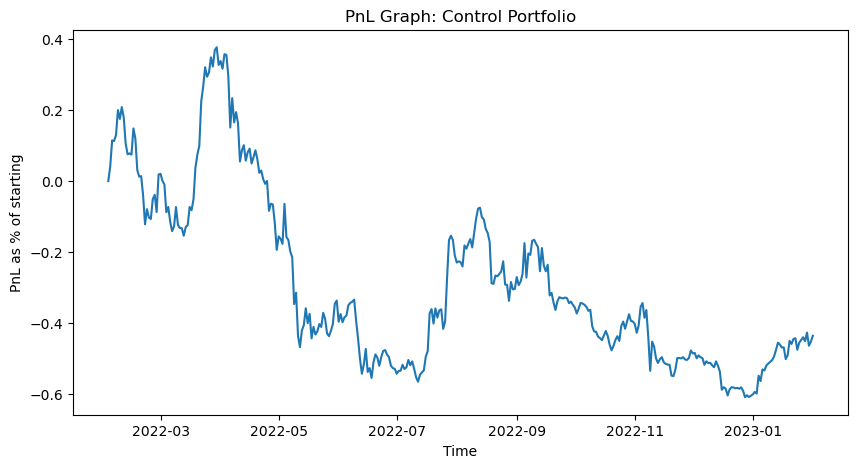

In [293]:
plt.figure(figsize=(10,5))
plt.plot((total_control['close']-100)/100)
plt.title('PnL Graph: Control Portfolio')
plt.xlabel('Time')
plt.ylabel('PnL as % of starting')
plt.show()

# Visualize Signal vs. Close for ETC

C:\Users\jonat\AppData\Local\Temp\ipykernel_24084\3665123260.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


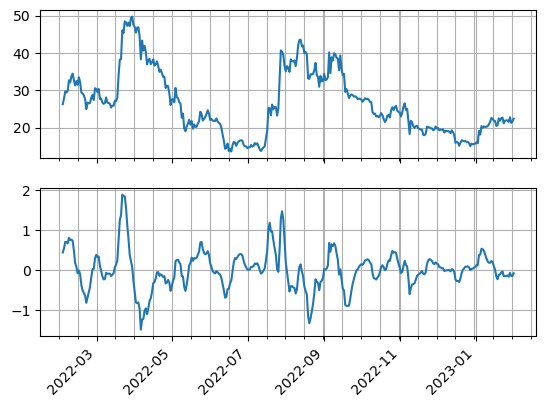

In [296]:
from matplotlib.ticker import AutoMinorLocator
plotMACD(etc_test_macd)